In [2]:
from helpers import *

## Benchmark

### Data

In [3]:
df = load_benchmark_data(load_ppo=True)

## Aggregate Metrics (rliable)

In [4]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

normalized_score_dict = {}
normalized_score_dict_samples = {}

for metric in metrics:
    normalized_score_dict[metric] = {}
    for algo in ALGOS:
        normalized_score_dict[metric][algo] = np.zeros((5, len(ENVS)))
        for i, env in enumerate(ENVS):
            df_filtered = df[df["Train/TotalSteps"] == 10000000]
            df_filtered = df_filtered[df_filtered["env"] == env]
            if metric == "Metrics/EpRet":
                norm = df_filtered[df_filtered["algo"]=="PPO"][metric].mean()
            elif metric == "Metrics/EpCost":
                norm = 25.0
            else:  # "Metrics/EpCumCostViolation"
                norm = df_filtered[df_filtered["algo"]=="CPO"][metric].mean()
            data = np.array(df_filtered[df_filtered["algo"]==algo][metric])
            if not data.size == 0:
                normalized_score_dict[metric][algo][:len(data),i] = data / norm
            else:
                print(f"Warning: empty data for {algo}, {env}")


In [4]:
import pickle

with open('../results/benchmark/eval_results.pickle', 'rb') as handle:
    eval_score_dict = pickle.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '../results/benchmark/eval_results.pickle'

In [1]:
for metric in ["eval_reward", "eval_cost"]:
    normalized_score_dict[metric] = {}
    for algo in ALGOS:
        normalized_score_dict[metric][algo] = np.zeros((5, len(ENVS)))
        for i, env in enumerate(ENVS):
            df_filtered = df[df["Train/TotalSteps"] == 10000000]
            df_filtered = df_filtered[df_filtered["env"] == env]
            if metric == "eval_reward":
                norm = np.array(eval_score_dict["eval_reward"]["ppo"][env]).mean()
            elif metric == "eval_cost":
                norm = 25.0
            else:  # "Metrics/EpCumCostViolation"
                raise ValueError()
            try:
                data = np.array(eval_score_dict[metric][algo.lower()][env])
            except KeyError:
                data = np.array(eval_score_dict[metric][algo.lower().replace("-", "_")][env])
            if not data.size == 0:
                normalized_score_dict[metric][algo][:,i] = data / norm
            else:
                print(f"Warning: empty data for {algo}, {env}")

NameError: name 'normalized_score_dict' is not defined

### Train Results

In [14]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

aggregate_scores, aggregate_score_cis = {}, {}

metric_names = [
    "Reward", 
    "Final Cost", 
    "Cumulative Cost"
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    #"eval_reward",
    #"eval_cost",
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

for metric, metric_name in zip(metrics, metric_names):
    aggregate_scores[metric_name], aggregate_score_cis[metric_name] = rly.get_interval_estimates(
        normalized_score_dict[metric], 
        rl_metrics.aggregate_iqm, 
        reps=50000
    )

In [15]:
as_df = pd.DataFrame(aggregate_scores).melt(ignore_index=False).reset_index()
as_df = as_df.rename(columns={"index": "algo", "variable": "metric"})

as_ci_df = pd.DataFrame(aggregate_score_cis).melt(ignore_index=False).reset_index()
as_ci_df = as_ci_df.rename(columns={"index": "algo", "variable": "metric", "value": "ci"})

as_df.merge(as_ci_df)

,algo,metric,value,ci
0,C-TRPO,Reward,0.696232,"[[0.6447690762191256], [0.7406793992042615]]"
1,CPO,Reward,0.680155,"[[0.6348198277977067], [0.7300590268494677]]"
2,PCPO,Reward,0.444720,"[[0.39934567742916965], [0.4887959530099512]]"
3,CPPO-PID,Reward,0.517230,"[[0.4593698121718999], [0.5689917742210211]]"
4,PPO-Lag,Reward,0.471180,"[[0.4162729057735701], [0.513853478276087]]"
5,TRPO-Lag,Reward,0.597762,"[[0.5150711393218502], [0.6750591793299021]]"
6,FOCOPS,Reward,0.614284,"[[0.5638519144016801], [0.6677832728958871]]"
7,CUP,Reward,0.648349,"[[0.5943212376623784], [0.7005600197649138]]"
8,P3O,Reward,0.451609,"[[0.4018568214141659], [0.504756087378018]]"
9,IPO,Reward,0.426489,"[[0.37032793534174263], [0.4881690885769163]]"


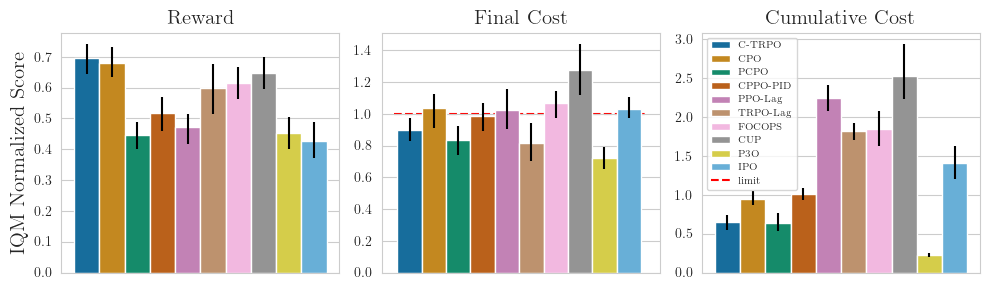

In [27]:
#sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 15.
mpl.rcParams["axes.labelsize"] = 15.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.serif'] = ['cm']
mpl.rcParams['font.family'] = "serif"
#mpl.rcParams['font.serif'] = ['CMU']

# cm = 1/2.54  # centimeters in inches

fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for metric_name, ax in zip(metric_names, axs):
    sns.barplot(as_df[as_df["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax)
    plt.tight_layout()

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:10]])))
    y = np.array(as_df[as_df["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df[as_df["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)

axs[1].plot([-0.41, 0.42], [1, 1], color="red", linestyle="dashed", label="limit", zorder=0)

handles, labels = axs[1].get_legend_handles_labels()
    
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)

plt.legend(handles, labels, prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("img", f"rliable_benchmark.pdf"), dpi=600)

In [17]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for metric in metrics:
    normalized_score_dict_samples[metric] = {}
    for algo in ALGOS:
        normalized_score_dict_samples[metric][algo] = np.zeros((5, len(ENVS), 10))
        for i, env in enumerate(ENVS):
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                if metric == "Metrics/EpRet":
                    norm = df_filtered[df_filtered["algo"]=="PPO"][df_filtered["Train/TotalSteps"] == 10_000_000][metric].mean()
                elif metric == "Metrics/EpCost":
                    norm = 25.0
                else:  # "Metrics/EpCumCostViolation"
                    norm = df_filtered[df_filtered["algo"]=="CPO"][df_filtered["Train/TotalSteps"] == 10_000_000][metric].mean()
                data = np.array(df_filtered[df_filtered["algo"]==algo][df_filtered["Train/TotalSteps"] == step][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[metric][algo][:,i,j] = data / norm
                else:
                    print(f"Warning: empty data for {algo}, {env}")

/tmp/ipykernel_210134/2046670837.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norm = df_filtered[df_filtered["algo"]=="PPO"][df_filtered["Train/TotalSteps"] == 10_000_000][metric].mean()
/tmp/ipykernel_210134/2046670837.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = np.array(df_filtered[df_filtered["algo"]==algo][df_filtered["Train/TotalSteps"] == step][metric])
/tmp/ipykernel_210134/2046670837.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  norm = df_filtered[df_filtered["algo"]=="PPO"][df_filtered["Train/TotalSteps"] == 10_000_000][metric].mean()
/tmp/ipykernel_210134/2046670837.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = np.array(df_filtered[df_filtered["algo"]==algo][df_filtered["Train/TotalSteps"] == step][metric])
/tmp/ipykernel_210134/2046670837.py:22: UserWarning: Boolean Series key will be reindexed to match D

KeyboardInterrupt: 

In [9]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

iqm_scores, iqm_cis = {}, {}

for metric, metric_name in zip(metrics, metric_names):
  iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                for frame in range(scores.shape[-1])])

  iqm_scores[metric_name], iqm_cis[metric_name] = rly.get_interval_estimates(
    normalized_score_dict_samples[metric], iqm, reps=50000)

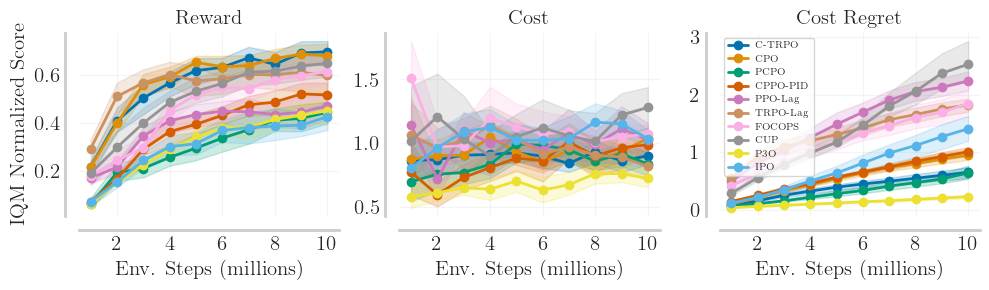

In [ ]:
_, axs = plt.subplots(1, 3, figsize=(10, 3))

for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
    plot_utils.plot_sample_efficiency_curve(
        np.array(range(1,11)), iqm_scores[metric_name], iqm_cis[metric_name], algorithms=ALGOS, ax=ax,
        xlabel=r'Env. Steps (millions)',
        ylabel="IQM Normalized Score" if i == 0 else "",
        labelsize=15,
        ticklabelsize=15,
        # legend=True if (i == 0) else False,
    )

    ax.set_title(metric_name, fontsize=15)
    ax.set_xticks([2, 4, 6, 8, 10])

plt.legend(prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("img", f"rliable_benchmark_samples.pdf"), dpi=600)

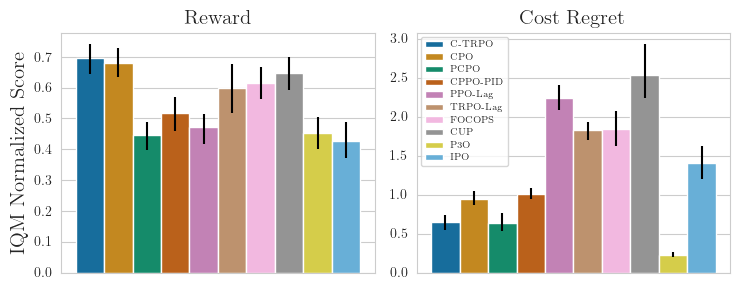

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=False)

for metric_name, ax in zip([metric_names[0], metric_names[2]], axs):
    sns.barplot(as_df[as_df["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax)
    plt.tight_layout()

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:10]])))
    y = np.array(as_df[as_df["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df[as_df["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("IQM Normalized Score" if metric_name == "Reward" else "")
    ax.set_title(metric_name)

handles, labels = axs[0].get_legend_handles_labels()
    
axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)

plt.legend(handles, labels, prop={'size': 6.5})

plt.tight_layout()

plt.savefig(os.path.join("img", f"rliable_benchmark_summary.pdf"), dpi=600)